In [1]:
%run flow_tools.py

In [2]:
folders = ['../data/20220214_K562Spike_JurkatSynNotch/NotchClassic/',
           '../data/20220214_K562Spike_JurkatSynNotch/KoleNotch/']

In [3]:
df = pd.concat([load_data(folder, colnames = ["WellName", "Receiver", "Sender",
                                              'Notch','Density','Replicate','Plate'])
               for folder in folders], ignore_index=True)
df2 = clean_data(df)

In [6]:
senders = ['None', 'K562', 'Spike-K562 (M)']
notches = ['No Notch','LCB1-Notch', 'LCB1(S)-Notch', 'LCB1(L)-Notch', 'LCB1(R)-Notch']
df2[(df2.Receiver.isin(notches)) & df2.Sender.isin(senders) & (df2.Notch.isin(['None','Classic']))].to_csv('notch_linkers.csv')

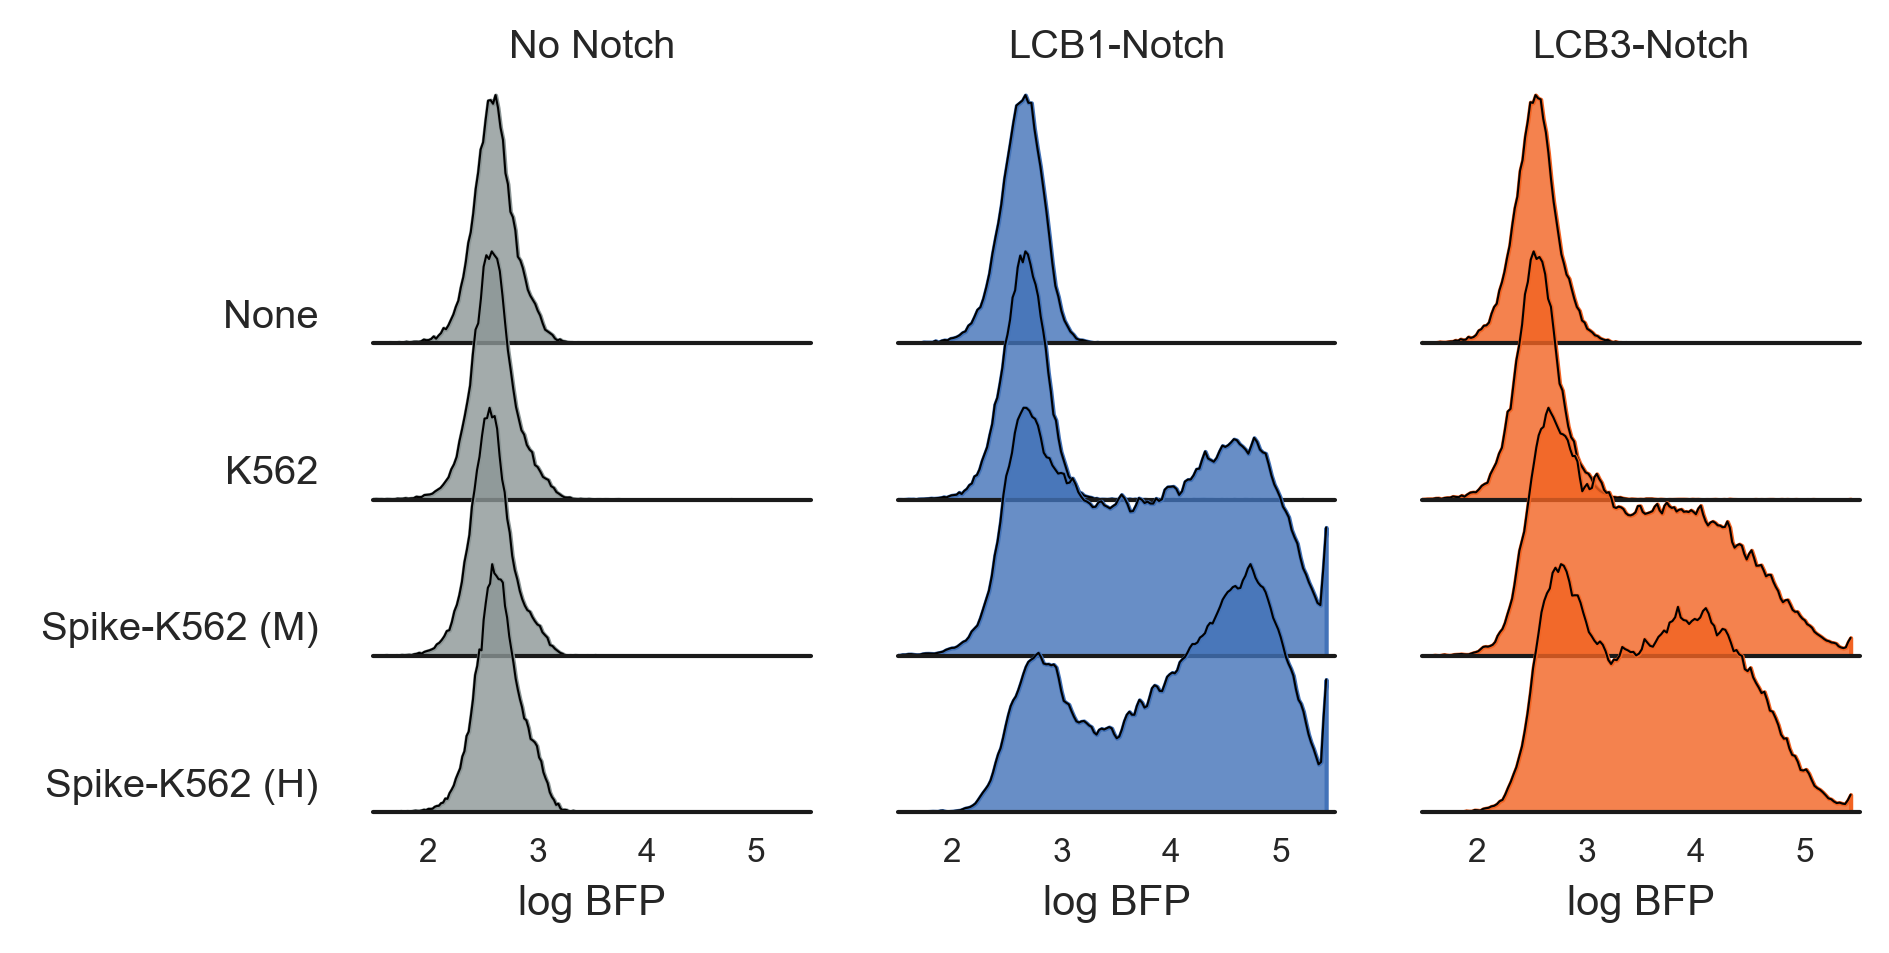

In [5]:
with sns.color_palette(["#8C9696", "#4272B8", "#F26322"]):
    senders = ['None', 'K562', 'Spike-K562 (M)', 'Spike-K562 (H)']
    notches = ['No Notch','LCB1-Notch', 'LCB3-Notch']
    g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(notches)) &
                               (df2['Notch'].isin(['None','Classic'])) &
                               (df2['logFITC-A'] > 5)],
                      row='Sender', col='Receiver', sharey=False, aspect=2.3, height=0.8, 
                      hue='Receiver', row_order=senders, col_order=notches, hue_order=notches, xlim=[1.5, 5.5])
    g.map(sns.kdeplot, "logDAPI-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logDAPI-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4, wspace=.2)

    left_axes = [g.facet_axis(r, 0) for r in range(len(senders))]
    for ax in left_axes:
        dose = ax.get_title().split("=")[1].split('|')[0]
        ax.text(-0.1,0.1, "{}".format(dose), ha="right", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes,
                size='large')

    g.set_titles("")
    top_axes = [g.facet_axis(0,c) for c in range(len(notches))]
    for ax, notch in zip(top_axes, notches):
        ax.set_title(notch, size='large')
    [ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]

    # Remove axes details that don't play well with overlap
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.set_xlabels("log BFP")
    g.set_ylabels('')
    g.fig.set_dpi(300)

In [11]:
filters = ((df2['logFITC-A'] > 5) &
           (df2.Receiver.isin(notches)) &
           (df2['Notch'].isin(['None','Classic'])))
dist = df2[filters]['logDAPI-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
df_summary = (df2[filters]
              .groupby(['Sender','Notch','Receiver','Replicate'])['logDAPI-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

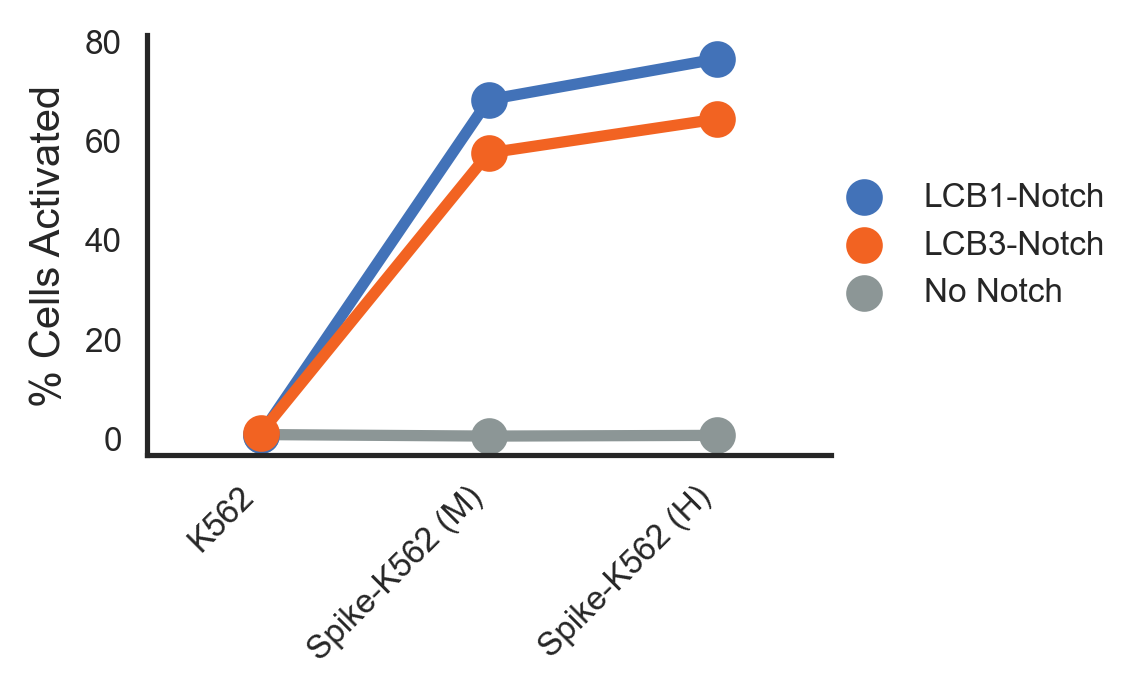

In [12]:
with sns.color_palette(["#8C9696", "#4272B8", "#F26322"]):
    g = sns.catplot(kind='point', data=df_summary[(df_summary['Receiver'].isin(notches))],
                    y='logDAPI-A', x='Sender', hue='Receiver', join=True, 
                    order=['K562', 'Spike-K562 (M)', 'Spike-K562 (H)'], 
                    hue_order=notches, height=2, aspect=1.5)
    g.set_xticklabels(rotation=45, ha='right')
    g.legend.remove()
    plt.xlabel('')
    plt.ylabel('% Cells Activated')
    handles, labels = g.ax.get_legend_handles_labels()
    order = [1,2,0]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='center', bbox_to_anchor=(1.2,0.5))
    g.fig.set_dpi(300)

In [14]:
filters = ((df2['logFITC-A'] > 5) &
           (df2.Receiver.isin(notches)) &
           (df2['Notch'].isin(['None','Classic'])))
df_summary = (df2[filters]
              .groupby(['Sender','Notch','Receiver','Replicate'])['logDAPI-A']
              .median()
              .reset_index())

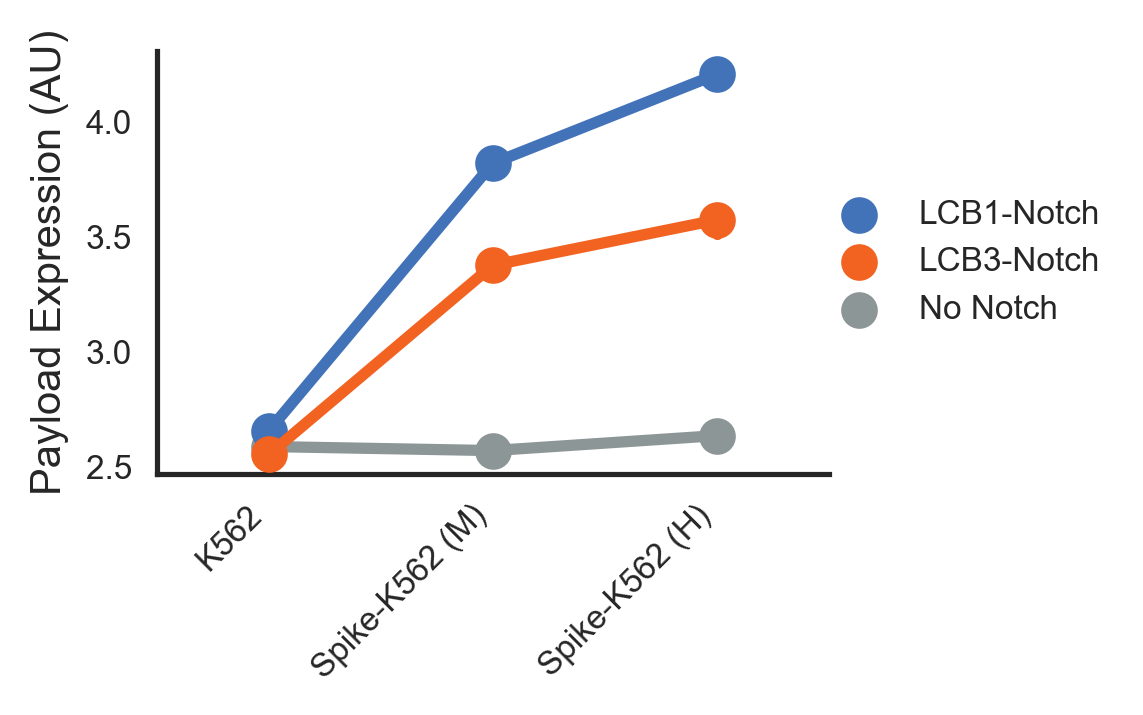

In [20]:
with sns.color_palette(["#8C9696", "#4272B8", "#F26322"]):
    g = sns.catplot(kind='point', data=df_summary[(df_summary['Receiver'].isin(notches))],
                    y='logDAPI-A', x='Sender', hue='Receiver', join=True, 
                    order=['K562', 'Spike-K562 (M)', 'Spike-K562 (H)'], 
                    hue_order=notches, height=2, aspect=1.5)
    g.set_xticklabels(rotation=45, ha='right')
    g.legend.remove()
    plt.xlabel('')
    plt.ylabel('Payload Expression (AU)')
    handles, labels = g.ax.get_legend_handles_labels()
    order = [1,2,0]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='center', bbox_to_anchor=(1.2,0.5))
    g.fig.set_dpi(300)

Text(0.5, 17.640000000000043, 'log <channel>')

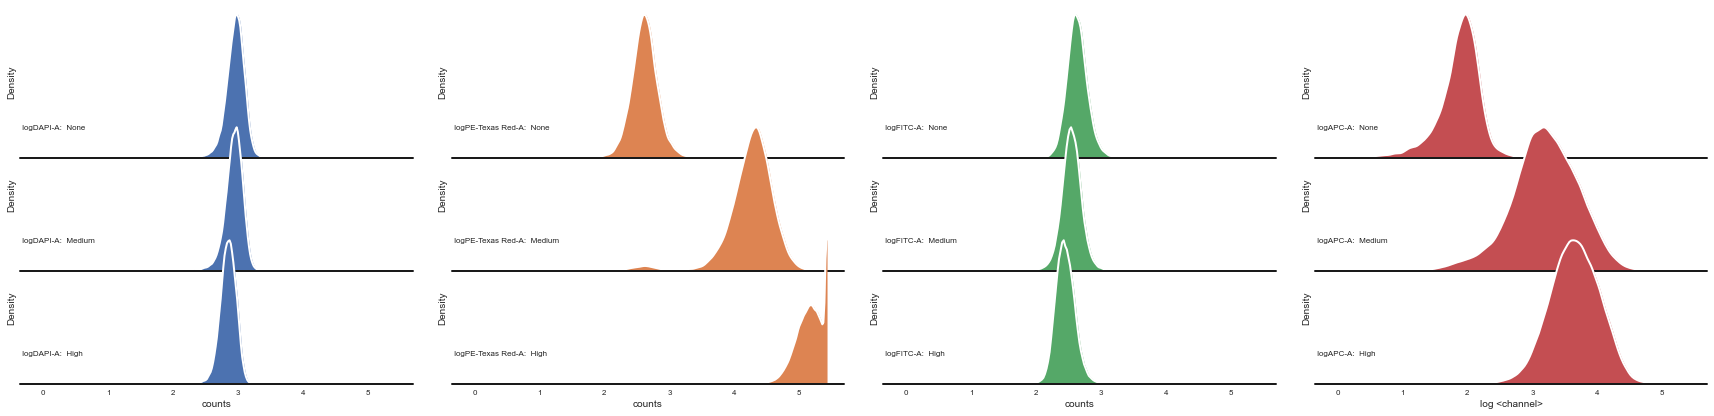

In [6]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logDAPI-A','logPE-Texas Red-A','logFITC-A', 'logAPC-A'], 
                       id_vars=['index','Plate','WellName','Sender','Receiver','Density', 'Notch'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[(simplified_df["Receiver"].isin(['None'])) &
                                     (simplified_df['Plate']=='1')], 
                  row = 'Density', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

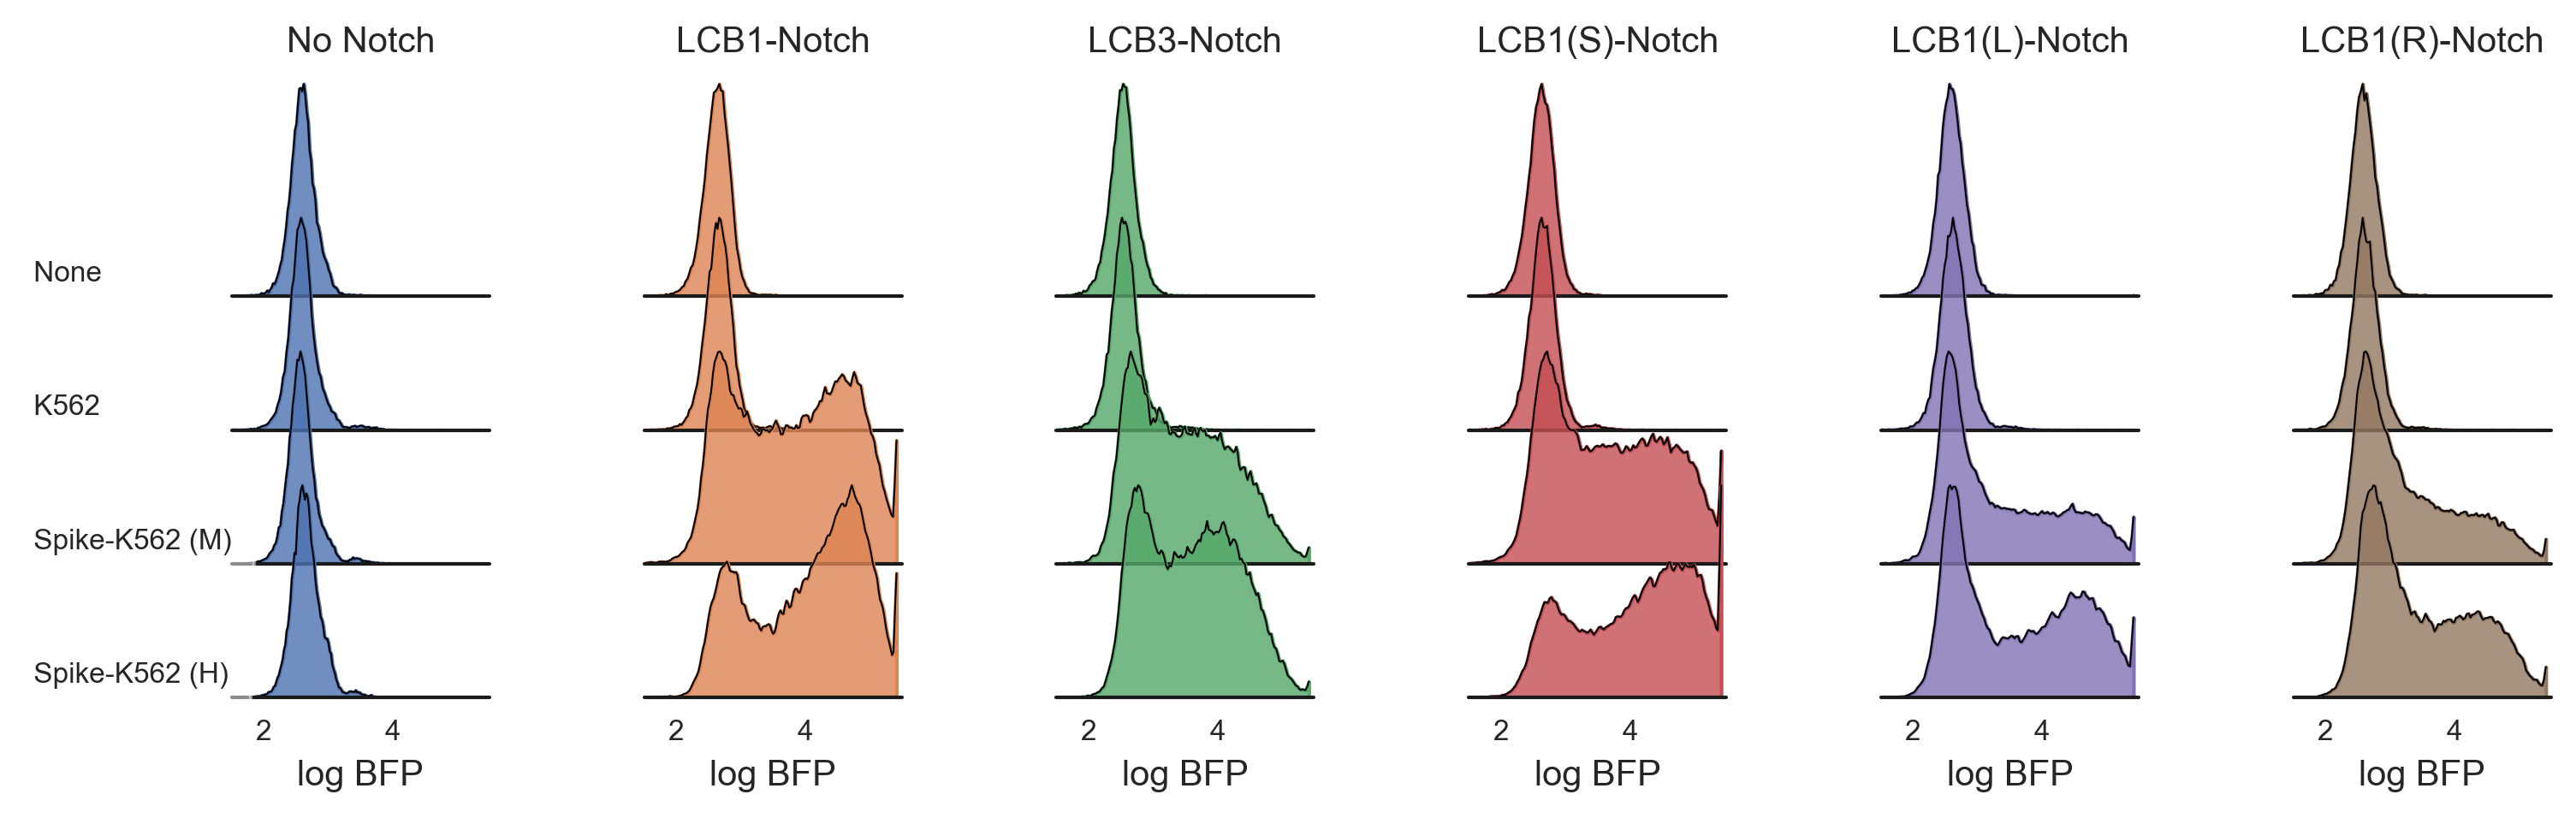

In [32]:
senders = ['None', 'K562', 'Spike-K562 (M)', 'Spike-K562 (H)']
notches = ['No Notch','LCB1-Notch', 'LCB3-Notch', 'LCB1(S)-Notch', 'LCB1(L)-Notch', 'LCB1(R)-Notch']
g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(notches)) &
                           (df2['Notch'].isin(['None','Classic'])) &
                           (df2['logFITC-A'] > 5)],
                  row='Sender', col='Receiver', sharey=False, aspect=2, height=0.8, 
                  hue='Receiver', row_order=senders, col_order=notches, hue_order=notches, xlim=[1.5, 5.5])
g.map(sns.kdeplot, "logDAPI-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
g.map(sns.kdeplot, "logDAPI-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.4)

left_axes = [g.facet_axis(r, 0) for r in range(len(senders))]
for ax in left_axes:
    dose = ax.get_title().split("=")[1].split('|')[0]
    ax.text(-0.8,0.1, "{}".format(dose), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)

g.set_titles("")
top_axes = [g.facet_axis(0,c) for c in range(len(notches))]
for ax, notch in zip(top_axes, notches):
    ax.set_title(notch)
[ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]

# Remove axes details that don't play well with overlap
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.set_xlabels("log BFP")
g.set_ylabels('')
g.fig.set_dpi(300)